# **Sentiment Analysis of Junky Union Movie Community**

# Project Goals

Junky Union Movie Community, a new community for classic movie fans is developing a system to filter and categorized movie reviews. Their ultimate mission is to train a model to automatically detect negative reviews. We will use the IMBD movie review dataset with polarity labeling to create a model to  classify positive and negative reviews. This model must have at least has an F1 score at 0.85.

## Initialization

In [9]:
import math

import numpy as np
import pandas as pd

import matplotlib
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import seaborn as sns

from tqdm.auto import tqdm

import io
from google.colab import files



In [10]:
#firstly, upload file to colab
#uploaded = files.upload()


In [11]:
#secondly, get path to file in colab
#file_path = io.BytesIO(uploaded['imdb_reviews.tsv'])

In [12]:
%matplotlib inline
%config InlineBackend.figure_format = 'png'
# the next line provides a better quality graphics on a HiDPI screen

# %config InlineBackend.figure_format = 'retina'

plt.style.use('seaborn')

<ipython-input-12-d8e172c59678>:7: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use('seaborn')


In [13]:
# this is for using progress_apply, read more at https://pypi.org/project/tqdm/# pandas-integration
tqdm.pandas()

## 1. Data Preparation

In [14]:
df_reviews = pd.read_csv('/content/imdb_reviews.tsv', sep='\t', dtype={'votes': 'Int64'}).sample(14000)

In [15]:
df_reviews.head(2)

,tconst,title_type,primary_title,original_title,start_year,end_year,runtime_minutes,is_adult,genres,average_rating,votes,review,rating,sp,pos,ds_part,idx
10627,tt0463967,movie,Donnybrook,Donnybrook,2005,\N,\N,0,Drama,6.0,33,"There is a difference between a ""film,"" and a ...",1,neg,0,test,11860
2234,tt0181288,movie,American Movie,American Movie,1999,\N,107,0,"Comedy,Documentary",7.9,16416,This movie sucked wind. I imagine that the oth...,1,neg,0,test,1468


In [16]:
df_reviews['pos'].value_counts()

0    7127
1    6873
Name: pos, dtype: int64

In [17]:
df_reviews['ds_part'].value_counts()

train    7033
test     6967
Name: ds_part, dtype: int64

In [18]:
df_reviews.shape

(14000, 17)

In [19]:
df_reviews.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 14000 entries, 10627 to 10072
Data columns (total 17 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   tconst           14000 non-null  object 
 1   title_type       14000 non-null  object 
 2   primary_title    14000 non-null  object 
 3   original_title   14000 non-null  object 
 4   start_year       14000 non-null  int64  
 5   end_year         14000 non-null  object 
 6   runtime_minutes  14000 non-null  object 
 7   is_adult         14000 non-null  int64  
 8   genres           14000 non-null  object 
 9   average_rating   13999 non-null  float64
 10  votes            13999 non-null  Int64  
 11  review           14000 non-null  object 
 12  rating           14000 non-null  int64  
 13  sp               14000 non-null  object 
 14  pos              14000 non-null  int64  
 15  ds_part          14000 non-null  object 
 16  idx              14000 non-null  int64  
dtypes: Int64

**Conclusion**

In the preparation stage we have the `imdb_reviews.tsv` dataset. And then we check the `imdb_reviews.tsv` dataset, which contains review information for movie categories that registered on IMDB. This dataset has 17 columns and 47331 rows of data. In this case, we perform an analysis using several machine learning models to help the Film Junky Union Movie Community find solutions to encounter their problems. After we check the dataset that has been provided, then we analyze the data, with using sample 14,000 rows data, to become more specific when we used for machine learning models. This time we use several models to find the best results.

## 2. Exploratory Data Analysis

Check the number of movies and reviews over the years.

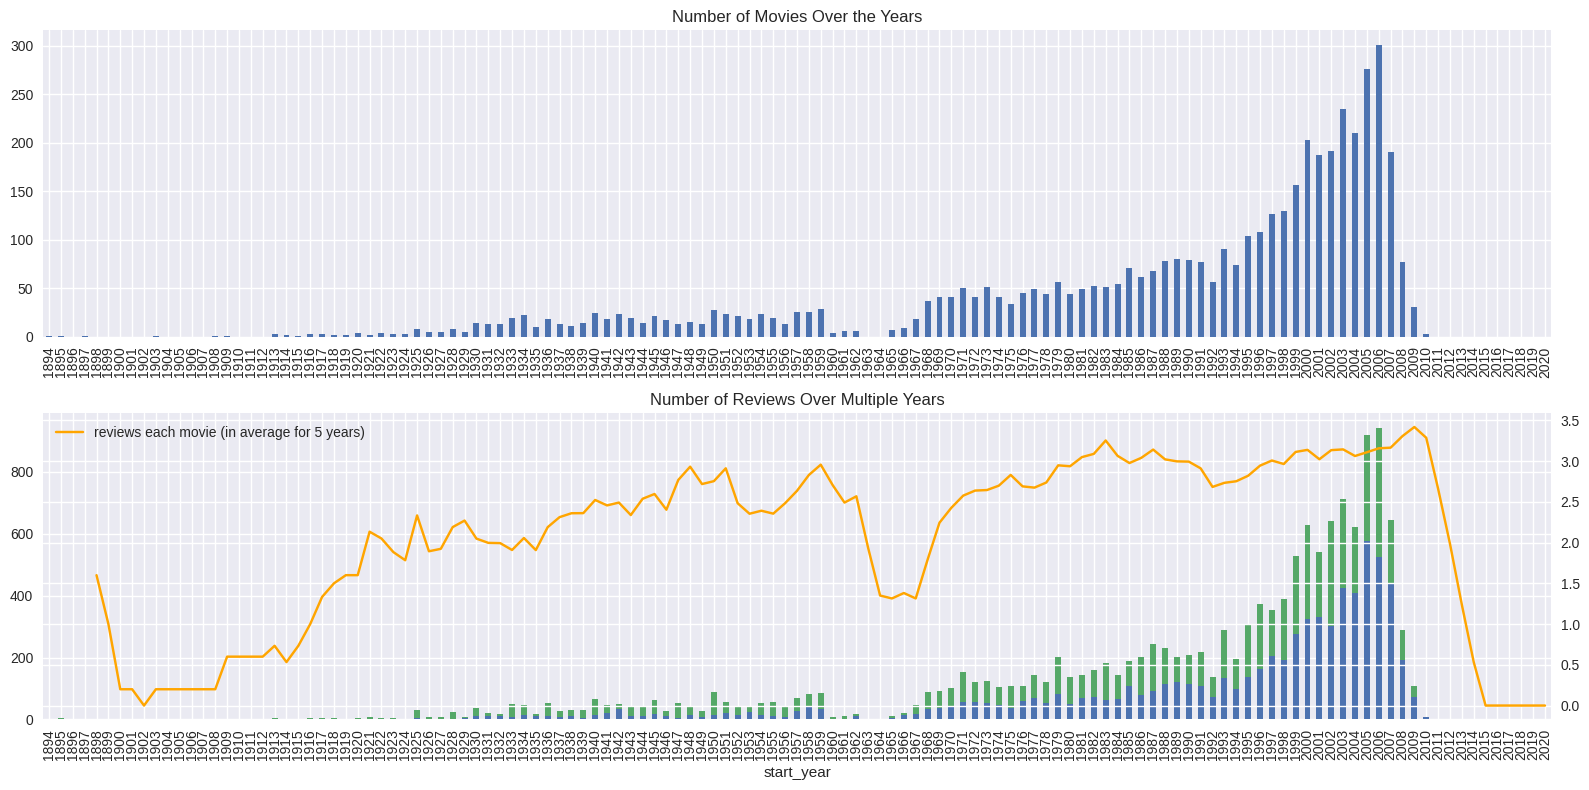

In [20]:
fig, axs = plt.subplots(2, 1, figsize=(16, 8))

ax = axs[0]

dft1 = df_reviews[['tconst', 'start_year']].drop_duplicates() \
    ['start_year'].value_counts().sort_index()
dft1 = dft1.reindex(index=np.arange(dft1.index.min(), max(dft1.index.max(), 2021))).fillna(0)
dft1.plot(kind='bar', ax=ax)
ax.set_title('Number of Movies Over the Years')

ax = axs[1]

dft2 = df_reviews.groupby(['start_year', 'pos'])['pos'].count().unstack()
dft2 = dft2.reindex(index=np.arange(dft2.index.min(), max(dft2.index.max(), 2021))).fillna(0)

dft2.plot(kind='bar', stacked=True, label='#reviews  (neg, pos)', ax=ax)

dft2 = df_reviews['start_year'].value_counts().sort_index()
dft2 = dft2.reindex(index=np.arange(dft2.index.min(), max(dft2.index.max(), 2021))).fillna(0)
dft3 = (dft2/dft1).fillna(0)
axt = ax.twinx()
dft3.reset_index(drop=True).rolling(5).mean().plot(color='orange', label='reviews each movie (in average for 5 years)', ax=axt)

lines, labels = axt.get_legend_handles_labels()
ax.legend(lines, labels, loc='upper left')

ax.set_title('Number of Reviews Over Multiple Years')

fig.tight_layout()

Check the distribution of number of reviews per movie with proper calculations and KDE (just to see how it has differences from exact calculation)

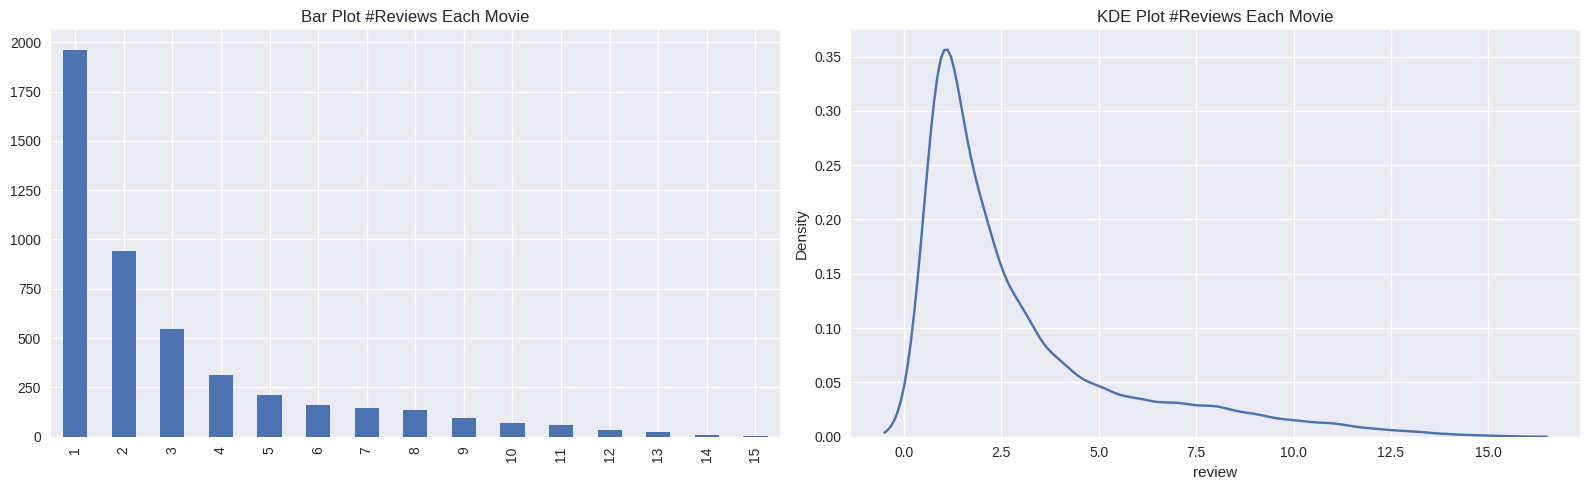

In [21]:
fig, axs = plt.subplots(1, 2, figsize=(16, 5))

ax = axs[0]
dft = df_reviews.groupby('tconst')['review'].count() \
    .value_counts() \
    .sort_index()
dft.plot.bar(ax=ax)
ax.set_title('Bar Plot #Reviews Each Movie')

ax = axs[1]
dft = df_reviews.groupby('tconst')['review'].count()
sns.kdeplot(dft, ax=ax)
ax.set_title('KDE Plot #Reviews Each Movie')

fig.tight_layout()

In [22]:
df_reviews['pos'].value_counts()

0    7127
1    6873
Name: pos, dtype: int64

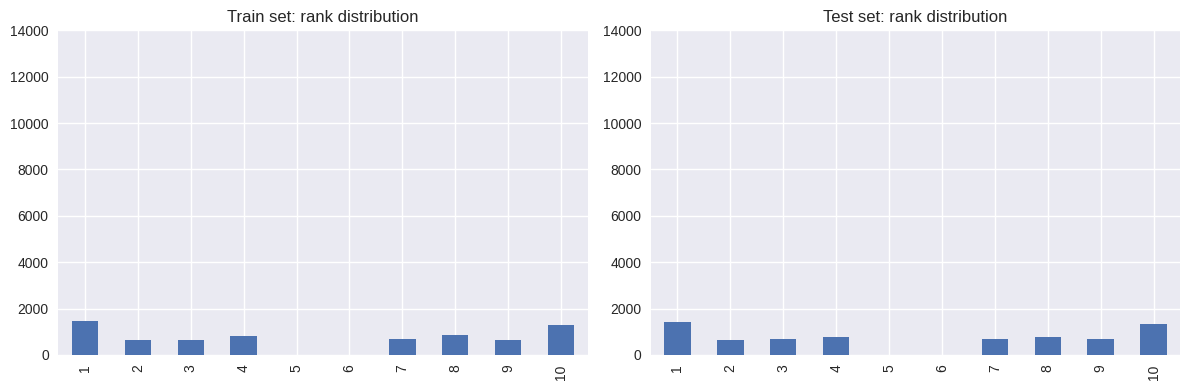

In [23]:
fig, axs = plt.subplots(1, 2, figsize=(12, 4))

ax = axs[0]
dft = df_reviews.query('ds_part == "train"')['rating'].value_counts().sort_index()
dft = dft.reindex(index=np.arange(min(dft.index.min(), 1), max(dft.index.max(), 11))).fillna(0)
dft.plot.bar(ax=ax)
ax.set_ylim([0, 14000])
ax.set_title('Train set: rank distribution')

ax = axs[1]
dft = df_reviews.query('ds_part == "test"')['rating'].value_counts().sort_index()
dft = dft.reindex(index=np.arange(min(dft.index.min(), 1), max(dft.index.max(), 11))).fillna(0)
dft.plot.bar(ax=ax)
ax.set_ylim([0, 14000])
ax.set_title('Test set: rank distribution')

fig.tight_layout()

Distribution of negative and positive reviews over the years for two sections of the *dataset*

<ipython-input-24-c89bfd25244c>:14: UserWarning: 

Support for alternate kernels has been removed; using Gaussian kernel.
This will become an error in seaborn v0.13.0; please update your code.

  sns.kdeplot(dft[0], color='blue', label='negative', kernel='epa', ax=ax)
<ipython-input-24-c89bfd25244c>:15: UserWarning: 

Support for alternate kernels has been removed; using Gaussian kernel.
This will become an error in seaborn v0.13.0; please update your code.

  sns.kdeplot(dft[1], color='green', label='positive', kernel='epa', ax=ax)
<ipython-input-24-c89bfd25244c>:30: UserWarning: 

Support for alternate kernels has been removed; using Gaussian kernel.
This will become an error in seaborn v0.13.0; please update your code.

  sns.kdeplot(dft[0], color='blue', label='negative', kernel='epa', ax=ax)
<ipython-input-24-c89bfd25244c>:31: UserWarning: 

Support for alternate kernels has been removed; using Gaussian kernel.
This will become an error in seaborn v0.13.0; please update your code.

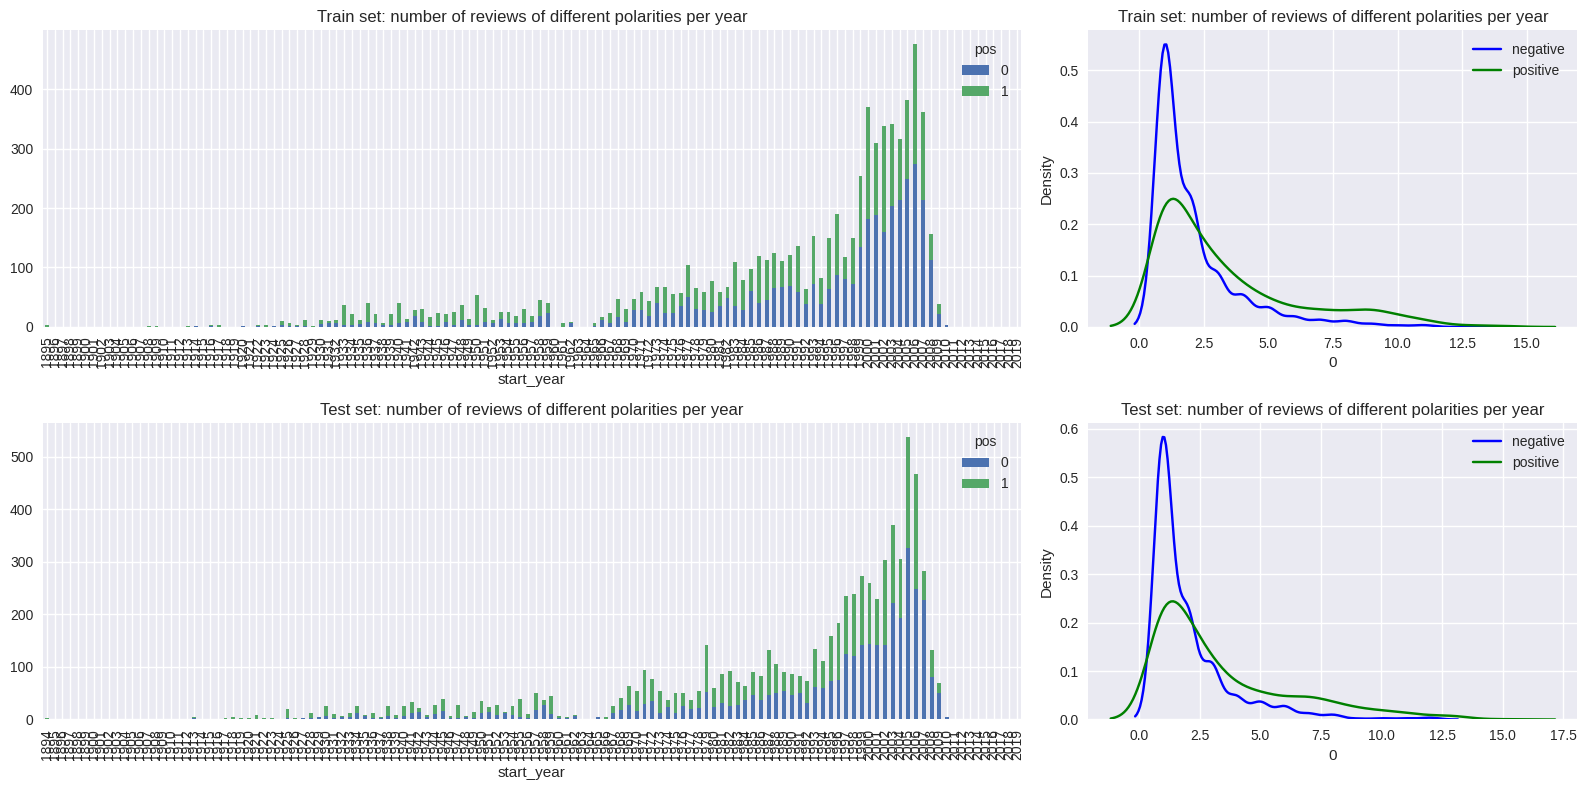

In [24]:
fig, axs = plt.subplots(2, 2, figsize=(16, 8), gridspec_kw=dict(width_ratios=(2, 1), height_ratios=(1, 1)))

ax = axs[0][0]

dft = df_reviews.query('ds_part == "train"').groupby(['start_year', 'pos'])['pos'].count().unstack()
dft.index = dft.index.astype('int')
dft = dft.reindex(index=np.arange(dft.index.min(), max(dft.index.max(), 2020))).fillna(0)
dft.plot(kind='bar', stacked=True, ax=ax)
ax.set_title('Train set: number of reviews of different polarities per year')

ax = axs[0][1]

dft = df_reviews.query('ds_part == "train"').groupby(['tconst', 'pos'])['pos'].count().unstack()
sns.kdeplot(dft[0], color='blue', label='negative', kernel='epa', ax=ax)
sns.kdeplot(dft[1], color='green', label='positive', kernel='epa', ax=ax)
ax.legend()
ax.set_title('Train set: number of reviews of different polarities per year')

ax = axs[1][0]

dft = df_reviews.query('ds_part == "test"').groupby(['start_year', 'pos'])['pos'].count().unstack()
dft.index = dft.index.astype('int')
dft = dft.reindex(index=np.arange(dft.index.min(), max(dft.index.max(), 2020))).fillna(0)
dft.plot(kind='bar', stacked=True, ax=ax)
ax.set_title('Test set: number of reviews of different polarities per year')

ax = axs[1][1]

dft = df_reviews.query('ds_part == "test"').groupby(['tconst', 'pos'])['pos'].count().unstack()
sns.kdeplot(dft[0], color='blue', label='negative', kernel='epa', ax=ax)
sns.kdeplot(dft[1], color='green', label='positive', kernel='epa', ax=ax)
ax.legend()
ax.set_title('Test set: number of reviews of different polarities per year')

fig.tight_layout()

**Conclusion**

After we carry out the plot above, it appears that some of the trends that we can analyze are as follows:

1. Based on the data visualization of `Number of Movies Over Several Years`, there was a significant increase in the number of films produced in 2005 and 2006 with figures exceeding 250 movie titles per year. This could be because there are several books or video games that were released on the market and then turned into a movie. And it can also happen because there are several movie titles that are late for release due to some reason
2. Based on the `Reviews each movie` visualization data, there is a total of **1750** review data. Maybe this movie was quite popular at the time.
3. Based on the `rating` data, there are a number of movies that have the highest rating on movies with `1` and `10` ratings
4. On the graph of the `distribution of negative and positive reviews over the years for two sections of the dataset`. We found that the density of negative reviews was very high, exceeding over the average level of positive reviews. This may be due to the fact that there was something controversial about the film, thus triggering a huge negative reviews from the audience.



## 3. Evaluation Procedure

Generate a usable evaluations for all models on a regular basis

In [25]:
import sklearn.metrics as metrics

def evaluate_model(model, train_features, train_target, test_features, test_target):

    eval_stats = {}

    fig, axs = plt.subplots(1, 3, figsize=(20, 6))

    for type, features, target in (('train', train_features, train_target), ('test', test_features, test_target)):

        eval_stats[type] = {}

        pred_target = model.predict(features)
        pred_proba = model.predict_proba(features)[:, 1]

        # F1
        f1_thresholds = np.arange(0, 1.01, 0.05)
        f1_scores = [metrics.f1_score(target, pred_proba>=threshold) for threshold in f1_thresholds]

        # ROC
        fpr, tpr, roc_thresholds = metrics.roc_curve(target, pred_proba)
        roc_auc = metrics.roc_auc_score(target, pred_proba)
        eval_stats[type]['ROC AUC'] = roc_auc

        # PRC
        precision, recall, pr_thresholds = metrics.precision_recall_curve(target, pred_proba)
        aps = metrics.average_precision_score(target, pred_proba)
        eval_stats[type]['APS'] = aps

        if type == 'train':
            color = 'blue'
        else:
            color = 'green'

        # F1 Score
        ax = axs[0]
        max_f1_score_idx = np.argmax(f1_scores)
        ax.plot(f1_thresholds, f1_scores, color=color, label=f'{type}, max={f1_scores[max_f1_score_idx]:.2f} @ {f1_thresholds[max_f1_score_idx]:.2f}')
        # set crosses for multiple thresholds
        for threshold in (0.2, 0.4, 0.5, 0.6, 0.8):
            closest_value_idx = np.argmin(np.abs(f1_thresholds-threshold))
            marker_color = 'orange' if threshold != 0.5 else 'red'
            ax.plot(f1_thresholds[closest_value_idx], f1_scores[closest_value_idx], color=marker_color, marker='X', markersize=7)
        ax.set_xlim([-0.02, 1.02])
        ax.set_ylim([-0.02, 1.02])
        ax.set_xlabel('threshold')
        ax.set_ylabel('F1')
        ax.legend(loc='lower center')
        ax.set_title(f'F1 Score')

        # ROC
        ax = axs[1]
        ax.plot(fpr, tpr, color=color, label=f'{type}, ROC AUC={roc_auc:.2f}')
        # set crosses for multiple thresholds
        for threshold in (0.2, 0.4, 0.5, 0.6, 0.8):
            closest_value_idx = np.argmin(np.abs(roc_thresholds-threshold))
            marker_color = 'orange' if threshold != 0.5 else 'red'
            ax.plot(fpr[closest_value_idx], tpr[closest_value_idx], color=marker_color, marker='X', markersize=7)
        ax.plot([0, 1], [0, 1], color='grey', linestyle='--')
        ax.set_xlim([-0.02, 1.02])
        ax.set_ylim([-0.02, 1.02])
        ax.set_xlabel('FPR')
        ax.set_ylabel('TPR')
        ax.legend(loc='lower center')
        ax.set_title(f'ROC Curve')

        # PRC
        ax = axs[2]
        ax.plot(recall, precision, color=color, label=f'{type}, AP={aps:.2f}')
        # set crosses for multiple thresholds
        for threshold in (0.2, 0.4, 0.5, 0.6, 0.8):
            closest_value_idx = np.argmin(np.abs(pr_thresholds-threshold))
            marker_color = 'orange' if threshold != 0.5 else 'red'
            ax.plot(recall[closest_value_idx], precision[closest_value_idx], color=marker_color, marker='X', markersize=7)
        ax.set_xlim([-0.02, 1.02])
        ax.set_ylim([-0.02, 1.02])
        ax.set_xlabel('recall')
        ax.set_ylabel('precision')
        ax.legend(loc='lower center')
        ax.set_title(f'PRC')

        eval_stats[type]['Accuracy'] = metrics.accuracy_score(target, pred_target)
        eval_stats[type]['F1'] = metrics.f1_score(target, pred_target)

    df_eval_stats = pd.DataFrame(eval_stats)
    df_eval_stats = df_eval_stats.round(2)
    df_eval_stats = df_eval_stats.reindex(index=('Accuracy', 'F1', 'APS', 'ROC AUC'))

    print(df_eval_stats)

    return

**Conclusion**

Then we create a function to complie evaluations that can be used for all models on a regular basis. In this model evaluation function there are several components to calculate F1, ROC, PRC scores which will help us to predict whatever model we make.

## 3. Normalization

We assume all models below can accept text in lowercase and without numbers, punctuation, etc.

In [26]:
df_reviews['review_norm'] = df_reviews['review'].str.lower().str.replace('[^a-zA-Z]', ' ')

<ipython-input-26-e27e94743923>:1: FutureWarning: The default value of regex will change from True to False in a future version.
  df_reviews['review_norm'] = df_reviews['review'].str.lower().str.replace('[^a-zA-Z]', ' ')


In [27]:
df_reviews['review']

10627    There is a difference between a "film," and a ...
2234     This movie sucked wind. I imagine that the oth...
2659     The movie seems disjointed and overall, poorly...
11194    There is some spectacular, heart stoppingly be...
11334    I viewed the movie for a second time on Septem...
                               ...                        
1085     The movie is steeped in religion, so it is imp...
44006    i have to admit thanks to this movie i'm now a...
4015     OK, please believe me when I say that this is ...
9753     Spawned by the same Monty Berman / Dennis Spoo...
10072    This is just a joke of a movie,they lost me al...
Name: review, Length: 14000, dtype: object

In [28]:
df_reviews['review_norm']

10627    there is a difference between a  film   and a ...
2234     this movie sucked wind  i imagine that the oth...
2659     the movie seems disjointed and overall  poorly...
11194    there is some spectacular  heart stoppingly be...
11334    i viewed the movie for a second time on septem...
                               ...                        
1085     the movie is steeped in religion  so it is imp...
44006    i have to admit thanks to this movie i m now a...
4015     ok  please believe me when i say that this is ...
9753     spawned by the same monty berman   dennis spoo...
10072    this is just a joke of a movie they lost me al...
Name: review_norm, Length: 14000, dtype: object

**Conclusion**

In the Normalization step we assume that all the models we generate can accept text in lowercase and without numbers, punctuation, etc. Therefore, we need to clean each review data, so it does not contain these components.

## 4. Train / Test Split

Fortunately, the entire *dataset* has been divided into *train/test*. The corresponding flag is `ds_part`.

In [29]:
df_reviews_train = df_reviews.query('ds_part == "train"').copy()
df_reviews_test = df_reviews.query('ds_part == "test"').copy()

train_target = df_reviews_train['pos']
test_target = df_reviews_test['pos']

print(df_reviews_train.shape)
print(df_reviews_test.shape)

(7033, 18)
(6967, 18)


**Conclusion**

Fortunately, the entire dataset has been divided into train/test. The corresponding flag is `ds_part`. So, we no longer need to separate train/test data.

## 5. Work with Models

### Model 0 - Constant

          train  test
Accuracy   0.49  0.49
F1         0.66  0.66
APS        0.49  0.49
ROC AUC    0.50  0.50


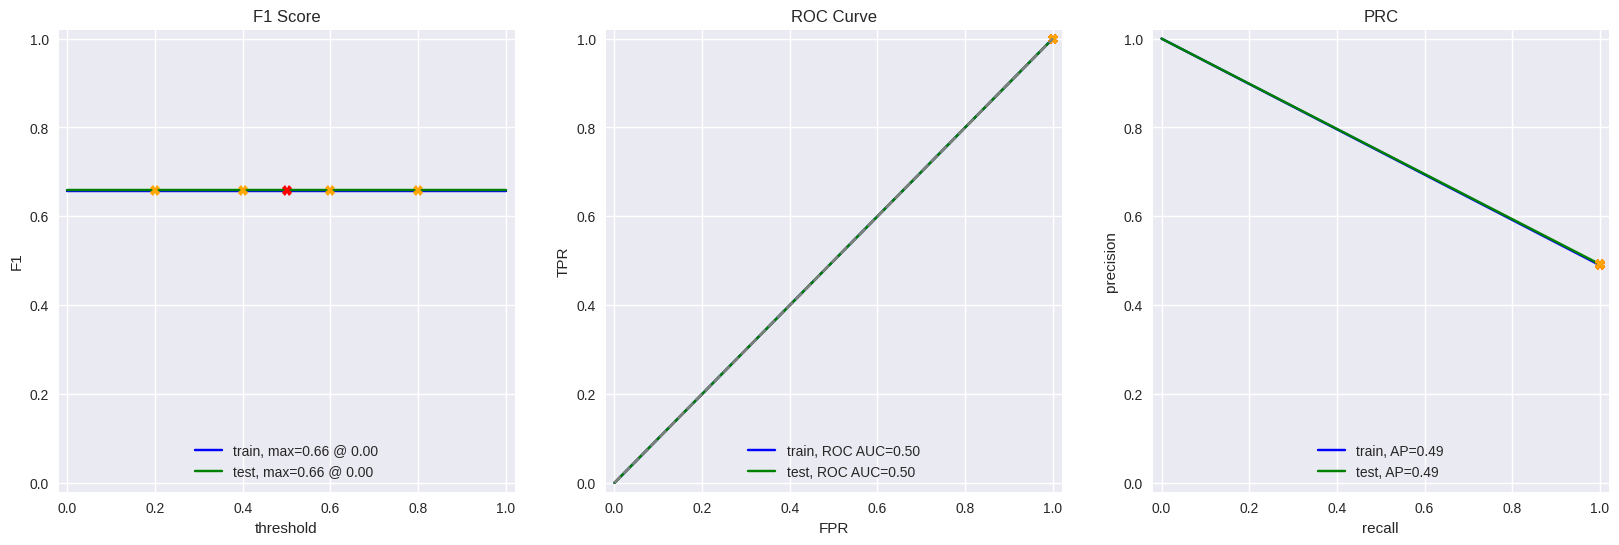

In [30]:
from sklearn.dummy import DummyClassifier

dummy_elf = DummyClassifier(strategy='constant', constant=1)

model_1 = dummy_elf.fit(X=df_reviews_train, y=train_target)

evaluate_model(model_1, np.empty(len(train_target)), train_target, np.empty(len(test_target)), test_target)

**Conclusion**

Work with the `DummyClassifier` constant model.

In this model we get an F1 score of `0.66` in the train set, and `0.66` in the test set. This is reasonable because the constant model is the basic model. Of course, it is still far from the F1 target score we need, which is 0.85.

### Model 1 - NLTK, TF-IDF dan LR

TF-IDF

In [31]:
import nltk

nltk.download('wordnet')
nltk.download('stopwords')

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression

from nltk.corpus import stopwords

[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [32]:
tfidf_vectorizer_1 = TfidfVectorizer(stop_words=stopwords.words('english'), lowercase=True)

train_features_1 = tfidf_vectorizer_1.fit_transform(df_reviews_train['review_norm'])
print(train_features_1.shape)

test_features_1 = tfidf_vectorizer_1.transform(df_reviews_test['review_norm'])
print(test_features_1.shape)

(7033, 44161)
(6967, 44161)


In [33]:
train_features_1.data[0]

0.08179926166019584

In [34]:
from sklearn.linear_model import LogisticRegression

model_2 = LogisticRegression(penalty='l1', solver='liblinear', C=0.5)

model_2.fit(train_features_1, train_target)

LogisticRegression(C=0.5, penalty='l1', solver='liblinear')

          train  test
Accuracy   0.82  0.82
F1         0.82  0.83
APS        0.90  0.89
ROC AUC    0.91  0.90


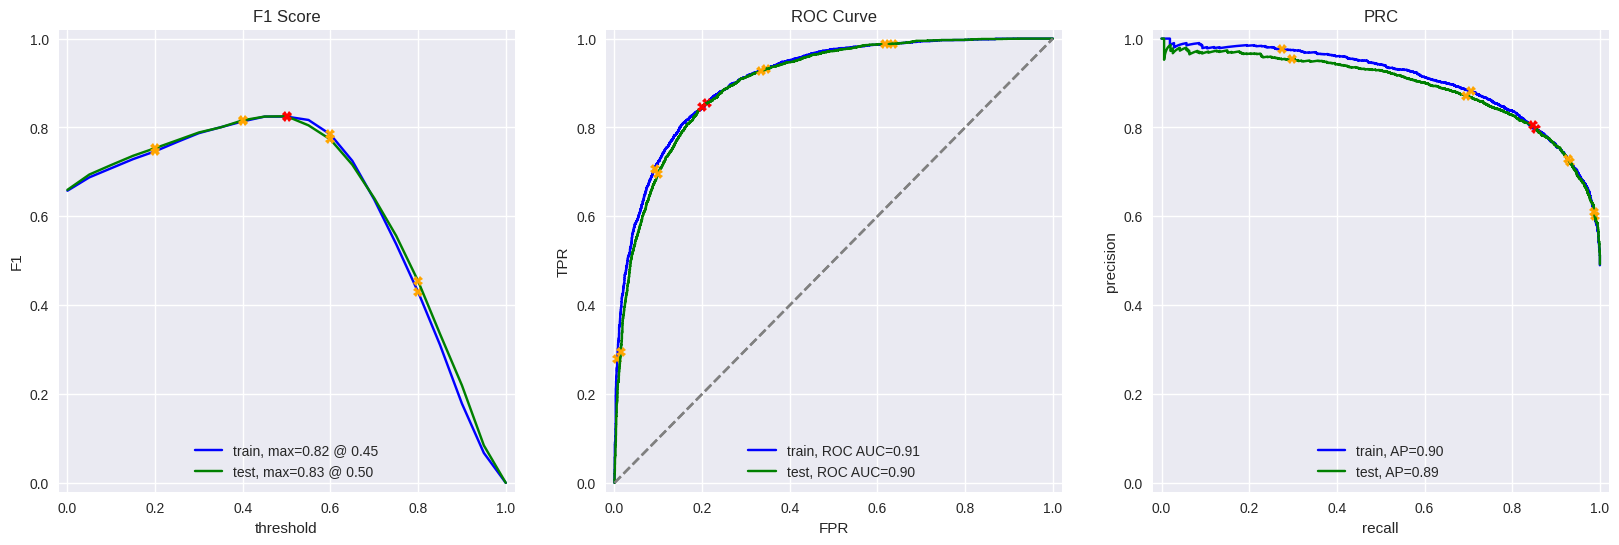

In [35]:
evaluate_model(model_2, train_features_1, train_target, test_features_1, test_target)

**Conclusion**

Working with the `LogisticRegression` model.

In this model we tune the model using library from **NLTK** to process text data, so it can be classified and has tokenization. Then, it is processed using the **TF-IDF** vectorization method to extract the features in the dataset.

In this model we get an F1 score of `0.82` in the train set, and `0.83` in the test set. This model is almost perfect. The value we have is a little closer to the F1 target score we need, which is 0.85.

### Model 3 - spaCy, TF-IDF dan LR

In [36]:
import spacy

nlp = spacy.load('en_core_web_sm', disable=['parser', 'ner'])

In [37]:
def text_preprocessing_3(text):

    doc = nlp(text)
    #tokens = [token.lemma_ for token in doc if not token.is_stop]
    tokens = [token.lemma_ for token in doc]

    return ' '.join(tokens)

In [38]:
#apply lemma to train dataset
df_reviews_train['review_tokenized_3'] = df_reviews_train['review_norm'].apply(lambda x: text_preprocessing_3(x))

In [39]:
#apply lemma to test dataset
df_reviews_test['review_tokenized_3'] = df_reviews_test['review_norm'].apply(lambda x: text_preprocessing_3(x))

In [40]:
df_reviews_train['review_tokenized_3'].sample(5)

743      some movie seem to be make before we be ready ...
25461    one of the good record of israel s response to...
938      although there be a lot of familiar   televisi...
23447    the most important thing about this movie be t...
12393    there be exactly    good thing to be say about...
Name: review_tokenized_3, dtype: object

In [41]:
df_reviews_test['review_tokenized_3'].sample(5)

18876    ok   so this be horror   I get horror    but I...
45649    I still find it hard to believe that a fine   ...
22147    it may be a little creaky now   and it certain...
33418    this extremely bargain basement blaxploitation...
5705     I think it be terrific   very realistic and fu...
Name: review_tokenized_3, dtype: object

In [42]:
tfidf_vectorizer_3 = TfidfVectorizer()

train_features_3 = tfidf_vectorizer_3.fit_transform(df_reviews_train['review_tokenized_3'])
print(train_features_3.shape)

test_features_3 = tfidf_vectorizer_3.transform(df_reviews_test['review_tokenized_3'])
print(test_features_3.shape)

(7033, 35661)
(6967, 35661)


In [43]:
model_3 = LogisticRegression(penalty='l1', solver='liblinear', C=0.5)

model_3.fit(train_features_3, train_target)

LogisticRegression(C=0.5, penalty='l1', solver='liblinear')

          train  test
Accuracy   0.83  0.83
F1         0.83  0.83
APS        0.91  0.90
ROC AUC    0.92  0.91


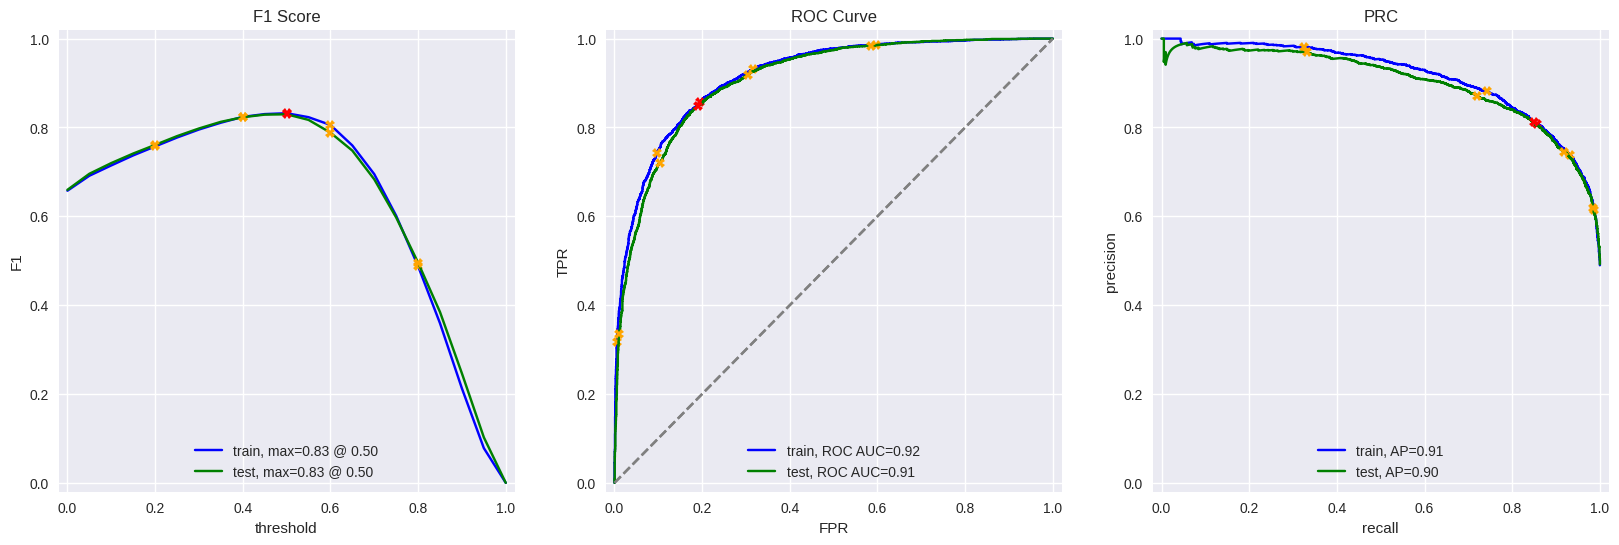

In [44]:
evaluate_model(model_3, train_features_3, train_target, test_features_3, test_target)

**Conclusion**

Working with the `LogisticRegression` model.

In this model, we tuned the model using the **spaCy** library with **lemma** function to process text data to get tokenization. Then, it is processed using the **TF-IDF** vectorization method to extract the features in the dataset.

In this model we get an F1 value of `0.83` in the train set, and `0.83` in the test set. The results are almost the same as in the previous process.

### Model 4 - spaCy, TF-IDF dan LGBMClassifier

In [45]:
from lightgbm import LGBMClassifier

In [46]:
model_4 = LGBMClassifier(learning_rate=0.01, max_depth=4)

model_4.fit(train_features_3, train_target)

LGBMClassifier(learning_rate=0.01, max_depth=4)

          train  test
Accuracy   0.74  0.73
F1         0.77  0.76
APS        0.83  0.81
ROC AUC    0.84  0.83


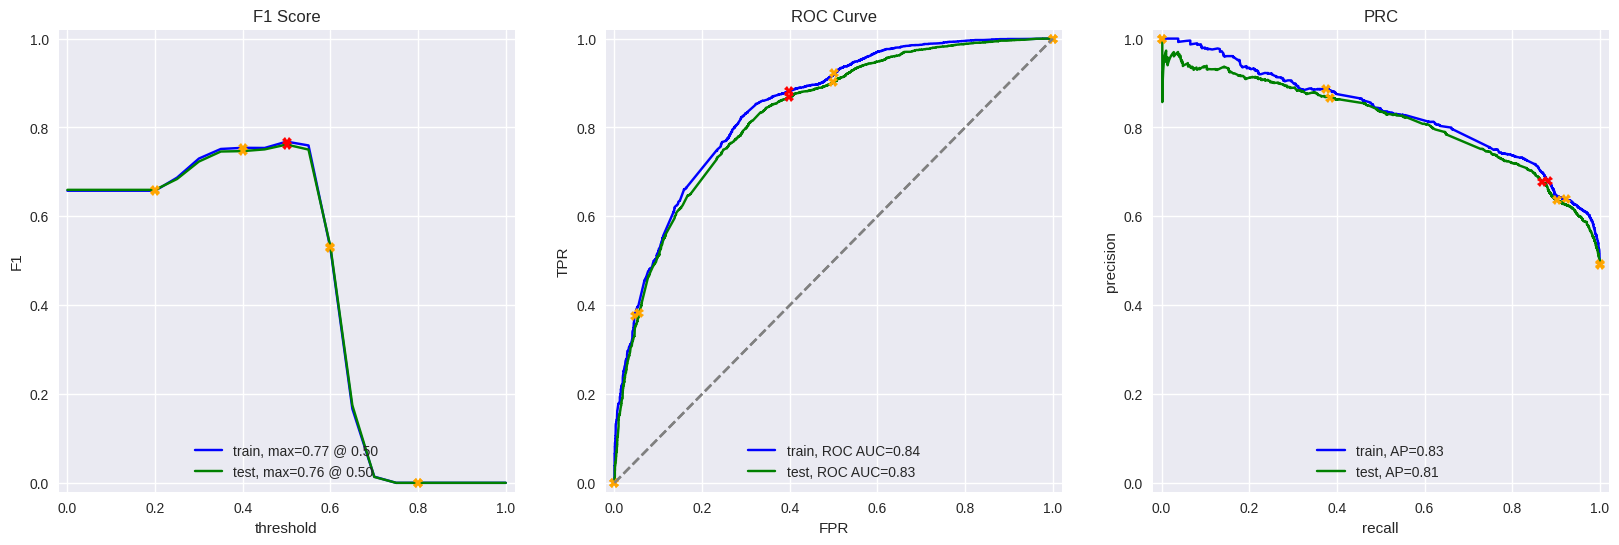

In [47]:
evaluate_model(model_4, train_features_3, train_target, test_features_3, test_target)

**Conclusion**

Works with the `LGBMClassifier` model with a `learning_rate` of `0.01`.

In this model, we tuned the model using **spaCy** library with **lemma** function to process text data to get tokenization. Then, it is processed using the **TF-IDF** vectorization method to extract the features in the dataset.

In this model we get an F1 value of `0.77` in the train set, and `0.76` in the test set. It turns out that the results have decreased.

###  Model 9 - BERT

In [48]:
import locale
locale.getpreferredencoding = lambda: "UTF-8" #use locale encode "UTF-8" for transformers installation

In [49]:
!pip install transformers

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.4/7.4 MB 47.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 268.8/268.8 kB 30.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 114.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 78.6 MB/s eta 0:00:00


In [50]:
import torch
import transformers

In [51]:
tokenizer = transformers.BertTokenizer.from_pretrained('bert-base-uncased')
config = transformers.BertConfig.from_pretrained('bert-base-uncased')
model = transformers.BertModel.from_pretrained('bert-base-uncased')

In [52]:
def BERT_text_to_embeddings(texts, max_length=512, batch_size=100, force_device=None, disable_progress_bar=False):

    ids_list = []
    attention_mask_list = []

    # text to token ID that has been padded along with the attention mask

    for input_text in tqdm(texts, disable=disable_progress_bar):
        ids = tokenizer.encode(input_text.lower(), add_special_tokens=True, truncation=True, max_length=max_length)
        padded = np.array(ids + [0]*(max_length - len(ids)))
        attention_mask = np.where(padded != 0, 1, 0)
        ids_list.append(padded)
        attention_mask_list.append(attention_mask)

    if force_device is not None:
        device = torch.device(force_device)
    else:
        device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

    model.to(device)
    if not disable_progress_bar:
        print(f'Use {device} device.')

    # get embedding in batches

    embeddings = []

    for i in tqdm(range(math.ceil(len(ids_list)/batch_size)), disable=disable_progress_bar):

        ids_batch = torch.LongTensor(ids_list[batch_size*i:batch_size*(i+1)]).to(device)

        attention_mask_batch = torch.LongTensor(attention_mask_list[batch_size*i:batch_size*(i+1)]).to(device)

        with torch.no_grad():
            model.eval()
            batch_embeddings = model(input_ids=ids_batch, attention_mask=attention_mask_batch)
        embeddings.append(batch_embeddings[0][:,0,:].detach().cpu().numpy())

    return np.concatenate(embeddings)

In [53]:
# Attention! Running BERT for thousands of texts may take a long time on the CPU, at least a few hours
train_features_9 = BERT_text_to_embeddings(df_reviews_train['review_norm'], force_device='cuda')

  0%|          | 0/7033 [00:00<?, ?it/s]

Use cuda device.


  0%|          | 0/71 [00:00<?, ?it/s]

<ipython-input-52-58dcf000e0ad>:30: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at ../torch/csrc/utils/tensor_new.cpp:245.)
  ids_batch = torch.LongTensor(ids_list[batch_size*i:batch_size*(i+1)]).to(device)


In [54]:
test_features_9 = BERT_text_to_embeddings(df_reviews_test['review_norm'], force_device='cuda')

  0%|          | 0/6967 [00:00<?, ?it/s]

Use cuda device.


  0%|          | 0/70 [00:00<?, ?it/s]

In [55]:
print(df_reviews_train['review_norm'].shape)
print(train_features_9.shape)
print(train_target.shape)

(7033,)
(7033, 768)
(7033,)


In [56]:
# if we already get the embedding, it's recommended to save it so it's ready to proceed
np.savez_compressed('features_9.npz', train_features_9=train_features_9, test_features_9=test_features_9)

# and load...
with np.load('features_9.npz') as data:
     train_features_9 = data['train_features_9']
     test_features_9 = data['test_features_9']

          train  test
Accuracy   0.90  0.85
F1         0.89  0.84
APS        0.96  0.92
ROC AUC    0.96  0.92


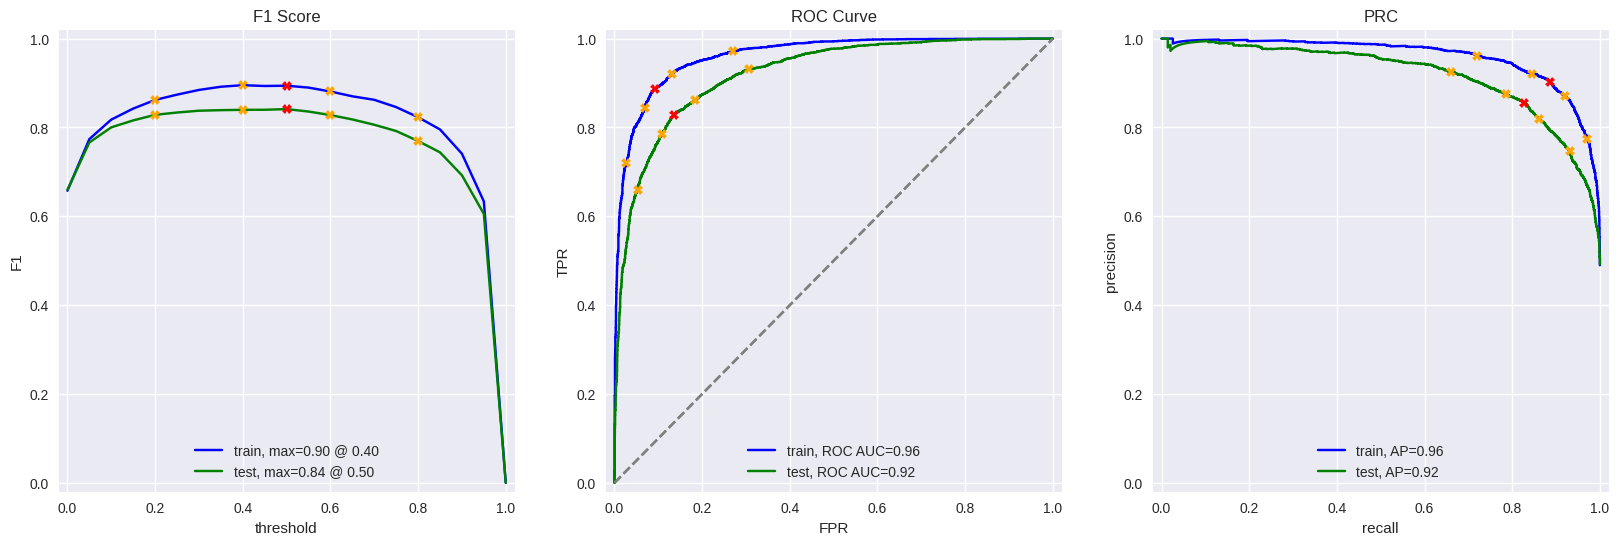

In [57]:
# After extracting the text embeddings using BERT, the next step is to train the model using LogisticRegression
from sklearn.linear_model import LogisticRegression

model_9 = LogisticRegression(max_iter=1000)
model_9.fit(train_features_9, train_target)

evaluate_model(model_9, train_features_9, train_target, test_features_9, test_target)

**Conclusion**

Working with the `LogisticRegression` model with a `max_iter` of `1000`.

In this model we tune the model using library from **BERT** with  `torch` and `transformers` functions to process text data to get tokenization. Then, it is processed using the embedding method and stores the feature in `features_9.npz`.

In this model we get an F1 score at `0.90` in the train set, and `0.84` in the test set. The value we have has exceeded the target F1 score we need, which is 0.85.

## 6. My Review

In [58]:
my_reviews = pd.DataFrame([
    'saya tidak begitu menyukainya, bukan jenis film kesukaan saya.',
    'Membosankan, bahkan saya tidur di tengah-tengah film.',
    'Filmnya sangat bagus, saya sangat suka',
    'Bahkan para aktornya terlihat sangat tua dan tidak tertarik dengan filmnya, apakah mereka dibayar untuk bermain film. Sungguh tidak bermutu.',
    'Saya tidak menyangka filmnya sebagus ini! Para penulis sungguh memperhatikan tiap detailnya',
    'Film ini memiliki kelebihan dan kekurangan, tetapi saya merasa secara keseluruhan ini adalah film yang layak. Saya mungkin akan menontonnya lagi.',
    'Beberapa lawakannya sungguh tidak lucu. Tidak ada satu pun lelucon yang berhasil, semua orang bertingkah menyebalkan, bahkan anak-anak pun tidak akan menyukai ini!',
    'Menayangkan film ini di Netflix adalah langkah yang berani & saya sangat senang bisa menonton episode demi episode dari drama baru yang menarik dan cerdas ini.'
], columns=['review'])

my_reviews['review_norm'] = my_reviews['review'].apply(lambda x: text_preprocessing_3(x))

my_reviews

,review,review_norm
0,"saya tidak begitu menyukainya, bukan jenis fil...","saya tidak begitu menyukainya , bukan jenis fi..."
1,"Membosankan, bahkan saya tidur di tengah-tenga...","Membosankan , bahkan saya tidur di tengah - te..."
2,"Filmnya sangat bagus, saya sangat suka","Filmnya sangat bagus , saya sangat suka"
3,Bahkan para aktornya terlihat sangat tua dan t...,bahkan para aktornya terlihat sangat tua dan t...
4,Saya tidak menyangka filmnya sebagus ini! Para...,saya tidak menyangka filmnya sebagus ini ! Par...
5,"Film ini memiliki kelebihan dan kekurangan, te...","film ini memiliki kelebihan dan kekurangan , t..."
6,Beberapa lawakannya sungguh tidak lucu. Tidak ...,Beberapa lawakannya sungguh tidak lucu . Tidak...
7,Menayangkan film ini di Netflix adalah langkah...,menayangkan film ini di Netflix adalah langkah...


### Model 2

In [59]:
texts = my_reviews['review_norm']

my_reviews_pred_prob = model_1.predict_proba(tfidf_vectorizer_1.transform(texts))[:, 1]

for i, review in enumerate(texts.str.slice(0, 100)):
    print(f'{my_reviews_pred_prob[i]:.2f}:  {review}')

1.00:  saya tidak begitu menyukainya , bukan jenis film kesukaan saya .
1.00:  Membosankan , bahkan saya tidur di tengah - tengah film .
1.00:  Filmnya sangat bagus , saya sangat suka
1.00:  bahkan para aktornya terlihat sangat tua dan tidak tertarik dengan filmnya , apakah mereka dibayar u
1.00:  saya tidak menyangka filmnya sebagus ini ! Para penuli sungguh memperhatikan tiap detailnya
1.00:  film ini memiliki kelebihan dan kekurangan , tetapi saya merasa secara keseluruhan ini adalah film y
1.00:  Beberapa lawakannya sungguh tidak lucu . Tidak ada satu pun lelucon yang berhasil , semua orang bert
1.00:  menayangkan film ini di Netflix adalah langkah yang berani & saya sangat senang bisa menonton episod


### Model 3

In [60]:
texts = my_reviews['review_norm']

my_reviews_pred_prob = model_3.predict_proba(tfidf_vectorizer_3.transform(texts.apply(lambda x: text_preprocessing_3(x))))[:, 1]

for i, review in enumerate(texts.str.slice(0, 100)):
    print(f'{my_reviews_pred_prob[i]:.2f}:  {review}')

0.48:  saya tidak begitu menyukainya , bukan jenis film kesukaan saya .
0.48:  Membosankan , bahkan saya tidur di tengah - tengah film .
0.48:  Filmnya sangat bagus , saya sangat suka
0.48:  bahkan para aktornya terlihat sangat tua dan tidak tertarik dengan filmnya , apakah mereka dibayar u
0.48:  saya tidak menyangka filmnya sebagus ini ! Para penuli sungguh memperhatikan tiap detailnya
0.48:  film ini memiliki kelebihan dan kekurangan , tetapi saya merasa secara keseluruhan ini adalah film y
0.48:  Beberapa lawakannya sungguh tidak lucu . Tidak ada satu pun lelucon yang berhasil , semua orang bert
0.61:  menayangkan film ini di Netflix adalah langkah yang berani & saya sangat senang bisa menonton episod


### Model 4

In [61]:
texts = my_reviews['review_norm']

tfidf_vectorizer_4 = tfidf_vectorizer_3
my_reviews_pred_prob = model_4.predict_proba(tfidf_vectorizer_4.transform(texts.apply(lambda x: text_preprocessing_3(x))))[:, 1]

for i, review in enumerate(texts.str.slice(0, 100)):
    print(f'{my_reviews_pred_prob[i]:.2f}:  {review}')

0.56:  saya tidak begitu menyukainya , bukan jenis film kesukaan saya .
0.56:  Membosankan , bahkan saya tidur di tengah - tengah film .
0.56:  Filmnya sangat bagus , saya sangat suka
0.56:  bahkan para aktornya terlihat sangat tua dan tidak tertarik dengan filmnya , apakah mereka dibayar u
0.56:  saya tidak menyangka filmnya sebagus ini ! Para penuli sungguh memperhatikan tiap detailnya
0.56:  film ini memiliki kelebihan dan kekurangan , tetapi saya merasa secara keseluruhan ini adalah film y
0.56:  Beberapa lawakannya sungguh tidak lucu . Tidak ada satu pun lelucon yang berhasil , semua orang bert
0.56:  menayangkan film ini di Netflix adalah langkah yang berani & saya sangat senang bisa menonton episod


### Model 9

In [62]:
texts = my_reviews['review_norm']

my_reviews_features_9 = BERT_text_to_embeddings(texts, disable_progress_bar=True)

my_reviews_pred_prob = model_9.predict_proba(my_reviews_features_9)[:, 1]

for i, review in enumerate(texts.str.slice(0, 100)):
    print(f'{my_reviews_pred_prob[i]:.2f}:  {review}')

0.82:  saya tidak begitu menyukainya , bukan jenis film kesukaan saya .
0.51:  Membosankan , bahkan saya tidur di tengah - tengah film .
0.88:  Filmnya sangat bagus , saya sangat suka
0.49:  bahkan para aktornya terlihat sangat tua dan tidak tertarik dengan filmnya , apakah mereka dibayar u
0.11:  saya tidak menyangka filmnya sebagus ini ! Para penuli sungguh memperhatikan tiap detailnya
0.97:  film ini memiliki kelebihan dan kekurangan , tetapi saya merasa secara keseluruhan ini adalah film y
0.99:  Beberapa lawakannya sungguh tidak lucu . Tidak ada satu pun lelucon yang berhasil , semua orang bert
0.88:  menayangkan film ini di Netflix adalah langkah yang berani & saya sangat senang bisa menonton episod


## 7. Final Conclusion

In the preparation stage we have the `imdb_reviews.tsv` dataset. And then we check the `imdb_reviews.tsv` dataset, which contains review information for movie categories that registered on IMDB. This dataset has 17 columns and 47331 rows of data. In this case, we perform an analysis using several machine learning models to help the Film Junky Union Movie Community find solutions to encounter their problems. After we check the dataset that has been provided, then we analyze the data, with using sample 14,000 rows data, to become more specific when we used for machine learning models. This time we use several models to find the best results.

After we carry out the plot above, it appears that some of the trends that we can analyze are as follows:

1. Based on the data visualization of `Number of Movies Over Several Years`, there was a significant increase in the number of films produced in 2005 and 2006 with figures exceeding 250 movie titles per year. This could be because there are several books or video games that were released on the market and then turned into a movie. And it can also happen because there are several movie titles that are late for release due to some reason
2. Based on the `Reviews each movie` visualization data, there is a total of **1750** review data. Maybe this movie was quite popular at the time.
3. Based on the `rating` data, there are a number of movies that have the highest rating on movies with `1` and `10` ratings
4. On the graph of the `distribution of negative and positive reviews over the years for two sections of the dataset`. We found that the density of negative reviews was very high, exceeding over the average level of positive reviews. This may be due to the fact that there was something controversial about the film, thus triggering a huge negative reviews from the audience.

Then we create a function to complie evaluations that can be used for all models on a regular basis. In this model evaluation function there are several components to calculate F1, ROC, PRC scores which will help us to predict whatever model we make.

In the Normalization step we assume that all the models we generate can accept text in lowercase and without numbers, punctuation, etc. Therefore, we need to clean each review data, so it does not contain these components.

Fortunately, the entire dataset has been divided into train/test. The corresponding flag is `ds_part`. So, we no longer need to separate train/test data.

We work with several models, including:
- `LogisticRegression`, using `NLTK`, `TFIDF`
- `LogisticRegression`, using `spaCy`, `TFIDF`
- `LGBMClassifier`, using `spaCy`, `TFIDF`
- `LogisticRegression`, using `BERT`

In the final model `LogisticRegression`, using `BERT` we get an F1 score at 0.90 in the train set, and 0.84 in the test set. The value we have has exceeded the target F1 score we need, which is 0.85.

After performed predictions, it turns out that the level of accuracy of a review has increased from one model to another. In model 9, we get the best accuracy with many accuracy numbers that close to `1.00`